**Learning note for galight**  
@Author: Rui Zhu  
@Cite: 2022 CSST Summer School

一些概念：  
1. PSO: 粒子群优化  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.io import fits
import os

# ^ 不显示warnings
import warnings
warnings.filterwarnings("ignore")

import galight.tools.astro_tools as astro_tools
from galight.data_process import DataProcess
from galight.fitting_specify import FittingSpecify
from galight.fitting_process import FittingProcess
from galight.tools.astro_tools import read_pixel_scale
from galight.tools.astro_tools import plt_fits

# Load the data

CID597_final_drz.fits loaded to pyfits
拍摄设备: HST WFC3 F125W
曝光时间: 2395.40s
pixel尺寸: 0.064200 arcsec/pixel


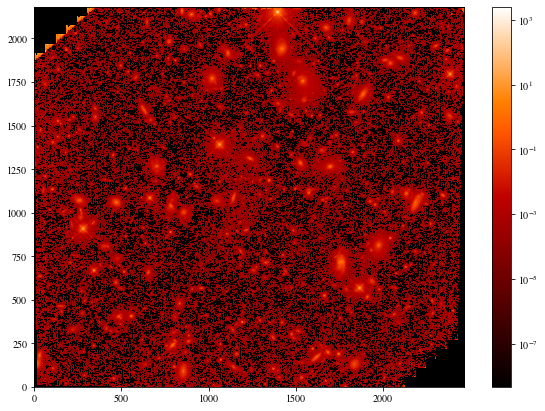

In [2]:
target_ID, RA, Dec = 'CID597', 150.5262, 2.2449

#读取QSO的fits文件。
print(target_ID + '_final_drz.fits', 'loaded to pyfits')
fitsFile = pyfits.open(os.path.join("./data", target_ID + '_final_drz.fits'))  

#从中读取数据:
fov_image = fitsFile[1].data # check the back grounp

#读取header信息:
header0 = fitsFile[0].header
header = fitsFile[1].header

#数据大致情况了解：
print('拍摄设备:',header0['TELESCOP'],header0['PRIMESI'],header0['FILTER'])
print('曝光时间: {0:.2f}s'.format(header0['EXPTIME']) )
print('pixel尺寸: {0:3f}'.format(read_pixel_scale(header)), 'arcsec/pixel')

#快速画出：
plt_fits(fov_image, colorbar=True, figsize=(10,7))

# 根据wht图像生成曝光图
wht = fitsFile[2].data
exp =  astro_tools.read_fits_exp(fitsFile[0].header)  #Read the exposure time 
exp_map = exp * wht /np.median(wht)  #Derive the exposure time map for each pixel

# 拟合材料准备

## 创建cutout, mask, noise map

Plot target cut out zoom in:


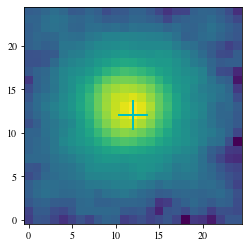

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

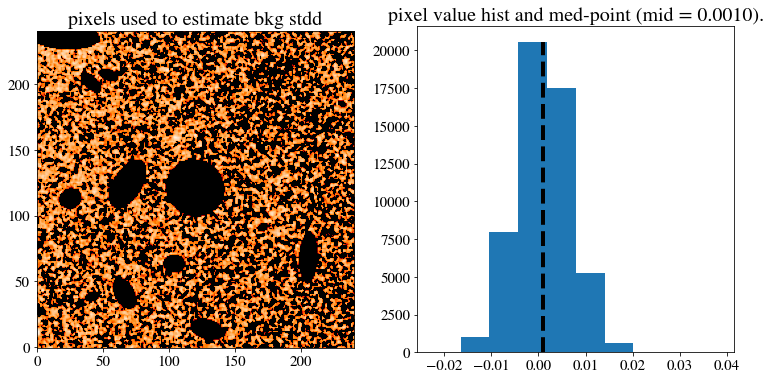

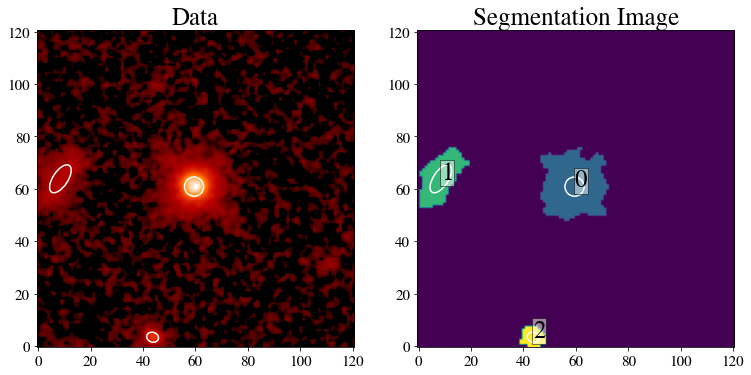

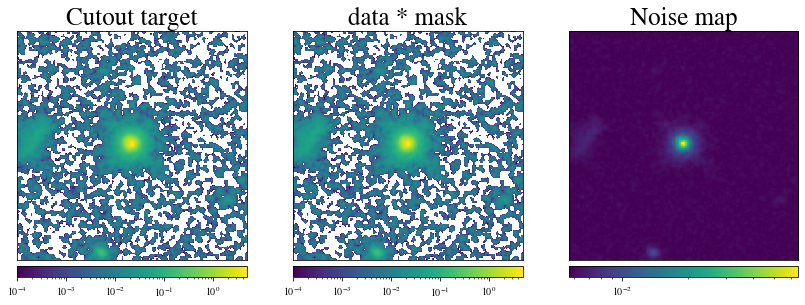

In [3]:
data_process = DataProcess(
    fov_image=fov_image, 
    target_pos=[RA, Dec], 
    pos_type='wcs', 
    header=header,  # 用来计算pixel大小
    rm_bkglight=False,  # 是否自动减掉背景光
    exptime = exp_map,
    if_plot=False, 
    zp = 26.450
    ) 


data_process.generate_target_materials(
    radius=60,  # cutout大小, 2*radius+1
    create_mask=False, 
    if_select_obj=False, # 一般选择False，这样会把FOV内所有目标都拟合；除非有目标非常难拟合，这时可以选择True，然后会有弹窗让你输入想要拟合的目标编号
    nsigma=2.8,  # 设定自动探测obj所需信噪比, 数值越小，灵敏度阈值越低，探测到的源越多
    npixels=15,  # 最小链接pixels的数量
    cut_kernel ='center_bright',
    if_plot=True
    )

## 选取PSF
从FOV中选取一个或几个PSF，用于之后对QSO进行拟合

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

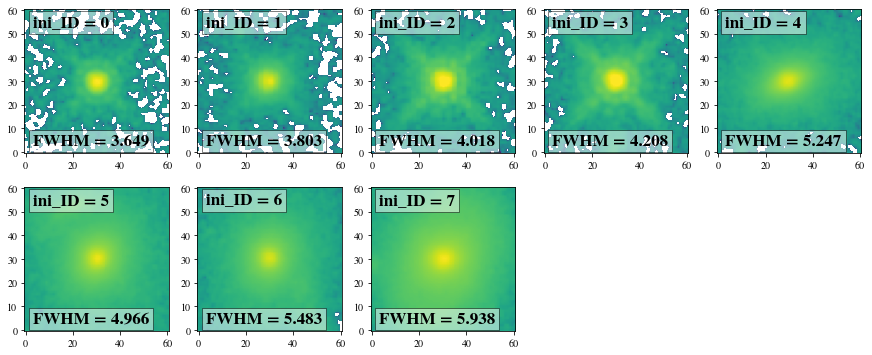

Input directly the PSF inital id to select, use space between each id:
 (press Enter to selet all)
 0


In [4]:
data_process.find_PSF(
    radius = 30, # PSF的尺寸, 2*radius+1
    if_filter=True, 
    nearyby_obj_filter=True,  # 自动过滤掉不合适的PSF
    user_option = True,
    FWHM_sort=False,  # FWHM越小，PSF越尖锐
    select_all=False
    )


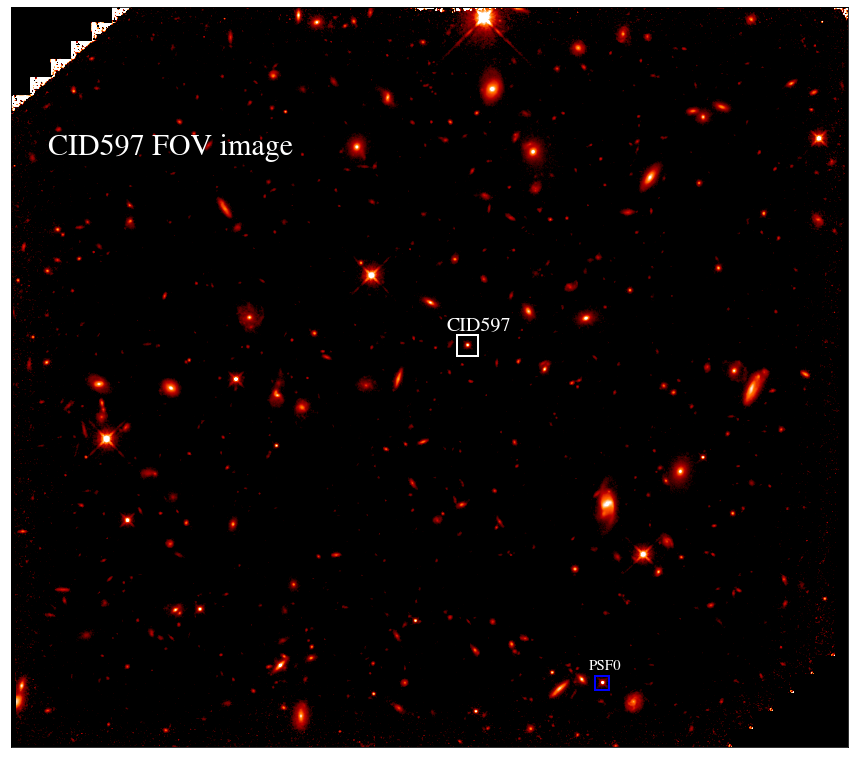

In [5]:
#Plot the FOV image and label the position of the target and the PSF
data_process.plot_overview(label = target_ID+' FOV image', target_label = target_ID)

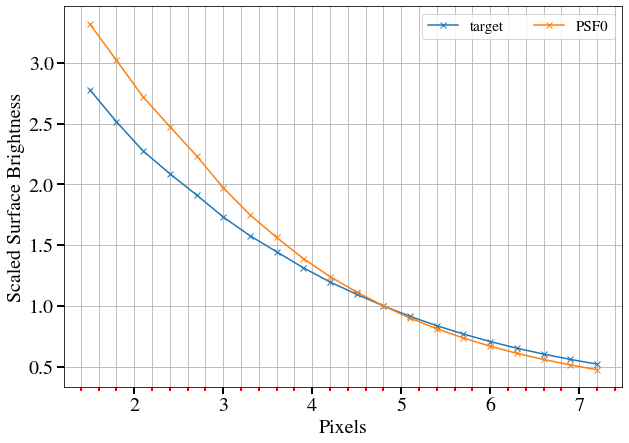

In [6]:
# Compare the 1D profile of all the components.
data_process.profiles_compare(
    norm_pix = 5, 
    if_annuli=False,
    y_log = False,
    prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) 
    )

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

EPSFBuilder converged after 6 iterations (of 10 maximum iterations)


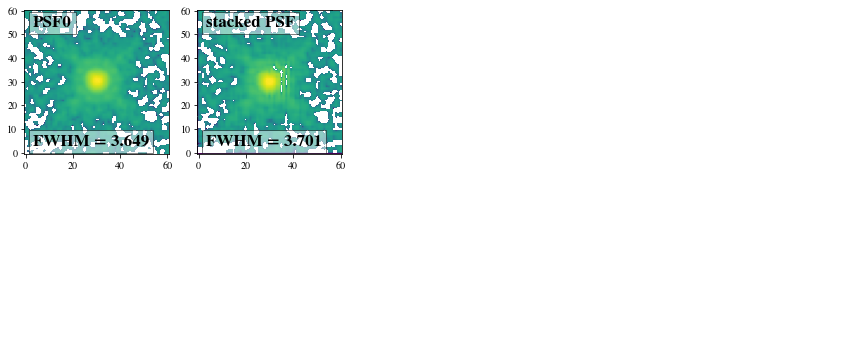

Plot residual:


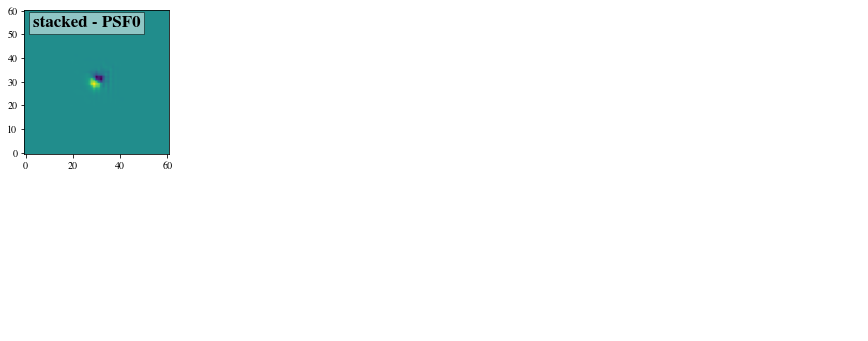

In [7]:
# ## 方式一，选择其中的某个PSF:
# data_process.psf_id_for_fitting = 0

## 方式二，使用emprical PSF:
data_process.stack_PSF()

## 确认需要的材料时候已经准备完毕

In [8]:
data_process.checkout()

The data_process is ready to go to pass to FittingSpecify!


# 设置模型与拟合

## 设置模型

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


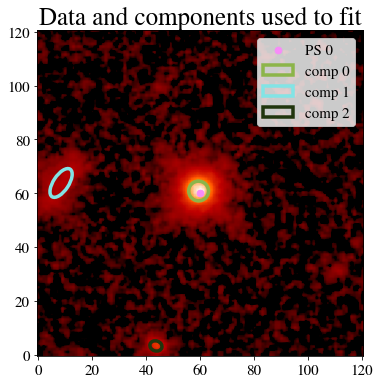

In [9]:
from galight.fitting_specify import FittingSpecify

#把data_process传递给FittingSpeficy
fit_sepc = FittingSpecify(data_process)

'''
设计模型的拟合方法:
point_source_num = 0 -> 单纯的星系, 不用AGN去拟合
point_source_num = 1 -> 类星体, 一个AGN成分
point_source_num = 2 -> 双AGN系统
'''
fit_sepc.prepare_fitting_seq(point_source_num = 1) 
# use also: fix_n_list= [[0,4]], fix_n_list= [[0,4]], fix_center_list = [[0,0]])
# 格式说明: fix_n_list=[[object_ID, sérsic n]]

#画出拟合的示意图：
fit_sepc.plot_fitting_sets()

#完成构建从而准备执行拟合：
fit_sepc.build_fitting_seq()

## 开始拟合

In [10]:
#录入fit_sepc:
fit_run = FittingProcess(
    fit_sepc, 
    savename = target_ID+'_fit_result', 
    fitting_level='deep'  # 可选'norm' or 'deep', deep会用更多的时间进行更精细的拟合
    ) 

#执行拟合
fit_run.run(algorithm_list = ['PSO'])

#如果需要的话，保存结果
fit_run.dump_result()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Max iteration reached! Stopping.
-1.1307340553818779 reduced X^2 of best position
-8263.969843758454 logL
14617.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.09505127063718777, 'n_sersic': 3.4416810764157604, 'e1': 0.026361453138352444, 'e2': -0.01738005499540804, 'center_x': 0.03322856257522483, 'center_y': 0.0747926804992956}, {'amp': 1, 'R_sersic': 0.5771095890949001, 'n_sersic': 0.3512888814181463, 'e1': -0.1557567149413158, 'e2': -0.3516269980431117, 'center_x': 3.3057893331903734, 'center_y': 0.23237958527677197}, {'amp': 1, 'R_sersic': 0.09094587138753817, 'n_sersic': 2.4000099690932277, 'e1': 0.18024857378911066, 'e2': 0.22883520837775534, 'center_x': 1.0425886662526993, 'center_y': -3.630876104358664}] lens light result
[{'ra_image': array([0.02208342]), 'dec_image': array([0.0268585]), 'point_amp': array([1.])}] point source result
{} special param result
67.

# 结果展示

## 读取`<result>.pkl`文件

In [ ]:
import pickle
pkl = open('CID597_fit_result.pkl', 'rb')
result = pickle.load(pkl)

result.plot_final_qso_fit(target_ID=target_ID, save_plot=False )

## 拟合图像展示

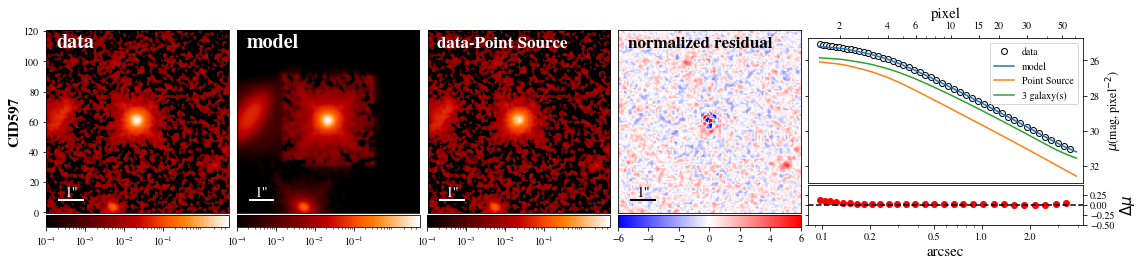

In [11]:
# fit_run.plot_all(target_ID=target_ID)
# fit_run.run_diag()
fit_run.plot_final_qso_fit(target_ID=target_ID, save_plot=False )

## 拟合数据展示

In [12]:
print("第'0'个galaxy的结果：\n",fit_run.final_result_galaxy[0])
print("第'0'个AGN的结果：\n",fit_run.final_result_ps[0])

第'0'个galaxy的结果：
 {'amp': 529.9341324579585, 'R_sersic': 0.09505127063718777, 'n_sersic': 3.4416810764157604, 'e1': 0.026361453138352444, 'e2': -0.01738005499540804, 'center_x': 0.03322856257522483, 'center_y': 0.0747926804992956, 'phi_G': -0.29144194951004, 'q': 0.9387825749087161, 'flux_sersic_model': 94.76394234760859, 'flux_within_frame': 91.28394772839897, 'magnitude': 21.549013965964456}
第'0'个AGN的结果：
 {'ra_image': array([0.02208342]), 'dec_image': array([0.0268585]), 'point_amp': array([41.78315125]), 'flux_within_frame': 41.77721335624531, 'magnitude': 22.39765132977195}


In [13]:
print("="*10 + ' Galaxy的结果 ' + "="*10)
fit_run.final_result_galaxy
# *数据格式为列表, 列表中的元素是每个星系成分参数组成的字典

========== Galaxy的结果 ==========


[{'amp': 529.9341324579585,
  'R_sersic': 0.09505127063718777,
  'n_sersic': 3.4416810764157604,
  'e1': 0.026361453138352444,
  'e2': -0.01738005499540804,
  'center_x': 0.03322856257522483,
  'center_y': 0.0747926804992956,
  'phi_G': -0.29144194951004,
  'q': 0.9387825749087161,
  'flux_sersic_model': 94.76394234760859,
  'flux_within_frame': 91.28394772839897,
  'magnitude': 21.549013965964456},
 {'amp': 10.465809523718775,
  'R_sersic': 0.5771095890949001,
  'n_sersic': 0.3512888814181463,
  'e1': -0.1557567149413158,
  'e2': -0.3516269980431117,
  'center_x': 3.3057893331903734,
  'center_y': 0.23237958527677197,
  'phi_G': -0.9938902166821207,
  'q': 0.4444814625916413,
  'flux_sersic_model': 12.822738644841973,
  'flux_within_frame': 11.78222717574227,
  'magnitude': 23.771931519477036},
 {'amp': 78.21229505736234,
  'R_sersic': 0.09094587138753817,
  'n_sersic': 2.4000099690932277,
  'e1': 0.18024857378911066,
  'e2': 0.22883520837775534,
  'center_x': 1.0425886662526993,
  'c

In [14]:
print("="*10 + ' AGN的结果 ' + "="*10)
fit_run.final_result_ps

========== AGN的结果 ==========


[{'ra_image': array([0.02208342]),
  'dec_image': array([0.0268585]),
  'point_amp': array([41.78315125]),
  'flux_within_frame': 41.77721335624531,
  'magnitude': 22.39765132977195}]

## host to total flux ratio

In [15]:
print("host to total flux ratio: {:.2f}".format(
    fit_run.final_result_galaxy[0]['flux_within_frame'] / (fit_run.final_result_galaxy[0]['flux_within_frame'] + fit_run.final_result_ps[0]['flux_within_frame'])
    )
)

host to total flux ratio: 0.69


## 寄主星系的形态分析
``galight``可以使用从之前步骤中得到的host图像中(i.e., QSO-AGN)中，分析寄主星系的形态学参数（其定义参见[reference](https://dx.doi.org/10.1093/mnras/sty3345)）。可计算内容包括:
- asymmetry
- concentration
- smoothness
- Gini

更详细的展示部分，参见此[notebook](https://github.com/dartoon/galight_notebooks/blob/master/galight_measure_asymmetry_CAS.ipynb).

Measuring the position for minimized asy...
Optimization terminated successfully.
         Current function value: 20.498485
         Iterations: 76
         Function evaluations: 151
Plot the minimized abs residual:


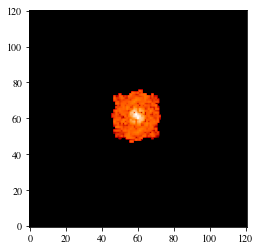

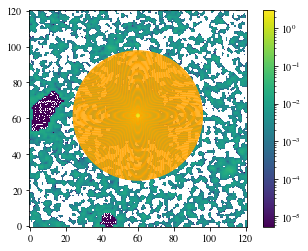

Plot the measure of petrosian radius:


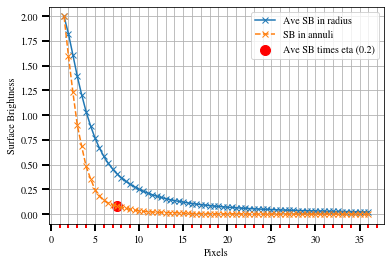

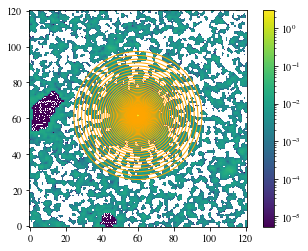

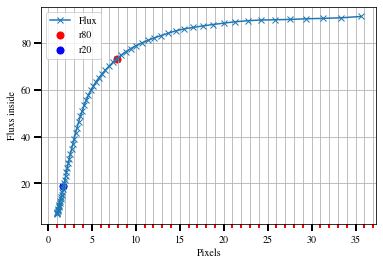

asymmetry: 0.19538152303006376
smoothness (by abs diff and pos diff): (0.14638059000433262, 0.14943254395270153)
concentration: 3.232574856347524
Gini: 0.5731460067147285


In [16]:
#测量寄主星系的形态：
from galight.tools.asymmetry_tools import CAS
CAS_class = CAS(fit_run, seg_cal_reg = 'or', obj_id=0, rm_ps=True, rm_obj=False) #Set rm_ps as True, meaning we are measuring the host.
cas = CAS_class.cal_CAS(mask_type='segm',extend=1, if_plot=True, radius=35)
print('asymmetry:', cas[0])
print('smoothness (by abs diff and pos diff):', cas[1])
print('concentration:', cas[2])
print('Gini:', cas[3])